# Data Reconciliation in ODYM - Part 1: Maximum Likelihood Estimation

Data reconciliation allows to adjust a MFA with conflicting data, enforce mass-balance and increase accuracy.

The STAN software (https://www.stan2web.net/support/mfa-basics/data-reconciliation) performs maximum likelihood estimation on a given system to be reconciled, and the algoritms is documented by *Cencic* in https://www.sciencedirect.com/science/article/pii/S246820391630053X, together with a worked exampled

The ODYM library reproduces the alghoritm with the method DataReconciliation() for a MFASystem() object. The same worked example as the STAN documention is reproduced here.

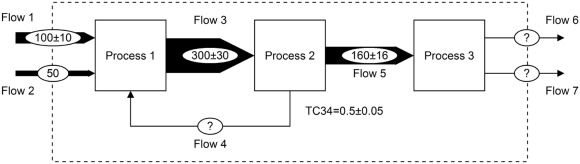

The maximum likelihood estimation of the DataReconciliation() method finds the Best Estimate (i.e. the most likely approximations of the true values) for flows and parameters, under the assumption that all values have **Normal distribution**.

In the example, Flows 1,3, and 5 have been empirically observed, and the uncertainty represents the standard deviation of the distribution.
Flow3 is a constant, i.e. an empirically true value that will not ne adjusted during data reconciliation. Flows 4,6, and 7 are unknown and there is no information available. Additionally, it is known that Flow4 is linked to Flow3 by the Tranfer Coefficient TC_34 (which has an empirically observed value) by the relationship

$$Flow_4=Flow_3\cdot TC_{34}.$$

Note that the DataReconciliation() method does not support multi-layer systems, meaning that one good/product/substance at a time can be considering, excluding time-dependent stock models as well. Multi-layer systems could be eventually explored with the MCMCDataReconciliation() methods, described in **Data Reconciliation in ODYM - Part 2**.

## 1) Importing libraries and defining system variables

In [1]:
import sys
import os

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(),'ODYM','odym','modules'))
import ODYM_Classes as msc
import ODYM_DataReconciliation as msr

## 2) Data reconciliation

The ODYM library is documented more extensively in the other tutorials.

### 2.1) Defining the system with mandatory instances

In [3]:
DR_System = msc.MFAsystem(Name=None, Geogr_Scope=None, Unit=None, Time_Start=None,
                            Time_End=None, IndexTable = None, Elements=None)

### 2.2) Define the system processes

In [4]:
DR_System.ProcessList = [
    #msc.Process(Name='Environment', ID=0),  #optional
    msc.Process(Name='Process 1', ID=1),
    msc.Process(Name='Process 2', ID=2),
    msc.Process(Name='Process 3', ID=3)    
    ] 

Note that **ID=0** is reserved for the environment outside of the system boundaries. Including the environment in the list of processes is optional, and no process inside the system boundaries can have ID=0.

### 2.3) Define the flows in the system

- *P_Start* and *P_End* represent the starting and ending processes respectively.
- *Values* represents the mean value of the observation. Use "None" for unobserved variables, i.e. unknowns.
- *Uncert* represents the observation uncertainty, i.e. the standard deviation of the observed values. Note that *Uncert* is expressed as percentage with respect to the observed value. Use "None" for constants.

In [5]:
DR_System.FlowDict['m01_1'] = msc.Flow(Name='Flow 1', P_Start=0, P_End=1, Values=100,  Uncert=10/100)
DR_System.FlowDict['m01_2'] = msc.Flow(Name='Flow 2', P_Start=0, P_End=1, Values=50,   Uncert=None)    
DR_System.FlowDict['m12']   = msc.Flow(Name='Flow 3', P_Start=1, P_End=2, Values=300,  Uncert=30/300)
DR_System.FlowDict['m21']   = msc.Flow(Name='Flow 4', P_Start=2, P_End=1, Values=None, Uncert=None)
DR_System.FlowDict['m23']   = msc.Flow(Name='Flow 5', P_Start=2, P_End=3, Values=160,  Uncert=16/160)
DR_System.FlowDict['m30_1'] = msc.Flow(Name='Flow 6', P_Start=3, P_End=0, Values=None, Uncert=None)
DR_System.FlowDict['m30_2'] = msc.Flow(Name='Flow 7', P_Start=3, P_End=0, Values=None, Uncert=None)

Eventually, **stock changes** could also be considered. 
For example, a stock change in process 2 would be described in the FlowDict using *None* as P_Start t and 2 as P_end.

### 2.4) Define the parameters in the system

*Values* and *Uncert* are defined similary to the system flows.

In [6]:
DR_System.ParameterDict['TC_34'] = msc.Parameter(Name='TransferCoefficient 1', Values=0.5, Uncert=0.05/0.5)

### 2.5) Define the model equations

The model equations. ie, how parameters and flow are linked, are defined in form of constraints: $F(flows, parameters)=0.$

In this example, there is only one trasfer coefficient: $Flow_4=Flow_3\cdot TC_{34}.$ In constraint form:

$$Flow_4 - Flow_3\cdot TC_{34}=0, \;\;\; \mbox{or alternatively:} \;\;\; Flow_3\cdot TC_{34}-Flow_4=0.$$
Both formulations would work. 

In [7]:
ParametersEquationsList = [
    'm21-m12*TC_34=0'
    ]  

### 2.6) Initial estimates

Data reconciliation is performed with a recursive alghoritm, and initial estimates for the first computation step for the unobserved variables have to be provided. Initial estimates are based on mass balance equations or alternatively transfer coefficients.

In [8]:
InitialEstimateDict = {
    'm21': 150,
    'm30_1': 80,
    'm30_2': 80
    }

### 2.7) Data reconciliation and results

In [9]:
results, mb = msr.DataReconciliation(DR_System,ParametersEquationsList,InitialEstimateDict) 

The DataReconciliation() method of the MFASystem object has two outputs: a summary table and a vector of mass-balance by process. 

The last columns of the table give information about the status of reconciliation for flows and parameters:
- *Observed value, reconciled*: the flow/parameter has an empirical value, which has now been reconciled.
- *Constant*: the flow/parameter is a constant of the system, i.e. no uncertainty was assigned.
- *Unknown, reconciled*: the flow/parameter did not have an empirical value, and the best estimate is given.
- *Cannot reconcile. Initial estimate only. Check for mass balance inconsistencies*: the system did not have enough information to provide the best estimate for all the flows/parameters and the initial estimate is reported. However, the value might break the mass-balance and further information are required.

If the system is not under-determined, the results table should give the final reconciled system. A successful reconciliation also delivers a vector of mass-balance with 0 for every process. 

Under-determined systems are explored in the next section.

In [10]:
print(results)

  Variable Observed value Observed sd  Reconciled value Reconciled sd  \
0    m01_1            100        10.0        102.425960      7.882792   
1    m01_2             50        None         50.000000          None   
2      m12            300        30.0        302.416229     22.608614   
3      m21           None        None        149.990270     21.213297   
4      m23            160        16.0        152.425960      7.882792   
5    m30_1           None        None         80.000000          None   
6    m30_2           None        None         80.000000          None   
7    TC_34            0.5        0.05          0.495973      0.037681   

                                               Notes  
0                         Observed value, reconciled  
1                                           Constant  
2                         Observed value, reconciled  
3                                Unknown, reconciled  
4                         Observed value, reconciled  
5  Cannot re

In [11]:
print(mb)

[0.0, 0.0, -7.574040341027569]


The system could not be fully reconciled and it was not possible to find a Best Estimate for Flow6 and Flow7. Their initial estimates, as set in the corresponding dictionary, break the mass-balance for process 3.

## 3) Equations and constraints

The systems has 8 variables to reconcile: 7 flows and 1 transfer coefficient.

In order to get the Best Estimate for each one of the variables, we then need at least 8 information sources. As we have 5 empirically observed values and 3 model constraints given by mass-balance equations, it may look the case.

However, while Process2 is **over-determined** (Flow3, Flow4, TC_34 and mass-balance are 4 information sources to the determine the 3 flows Flow3, Flow4 and Flow5), Process3 is **under-determined**: Flow5 and mass-balance are not enough information to determine Flow5, Flow6, and Flow7.


This means that there is not enough information to estimate both Flow6 and Flow7 and additionally information is required.



### 3.1) Example

Assume that equal outflows from Process3 are a meaningful choice. Then $Flow_6=Flow_7$, and in constraints form 

$$Flow_6-Flow_7=0.$$

This corresponds to the model equation $$Flow_6-Flow_7\cdot TC_{67}=0$$ with $TC_{67}=1$ and no uncertainty.

The lists of parameters and equations can be updated and Data Reconciliation performed again, including the new parameter.

In [12]:
DR_System2 = msc.MFAsystem(Name=None, Geogr_Scope=None, Unit=None, Time_Start=None,
                            Time_End=None, IndexTable = None, Elements=None)

DR_System2.ProcessList = [
    #msc.Process(Name='Environment', ID=0), #optional
    msc.Process(Name='Process 1', ID=1),
    msc.Process(Name='Process 2', ID=2),
    msc.Process(Name='Process 3', ID=3)    
    ] 

DR_System2.FlowDict['m01_1'] = msc.Flow(Name='Flow 1', P_Start=0, P_End=1, Values=100,  Uncert=10/100)
DR_System2.FlowDict['m01_2'] = msc.Flow(Name='Flow 2', P_Start=0, P_End=1, Values=50,   Uncert=None)    
DR_System2.FlowDict['m12']   = msc.Flow(Name='Flow 3', P_Start=1, P_End=2, Values=300,  Uncert=30/300)
DR_System2.FlowDict['m21']   = msc.Flow(Name='Flow 4', P_Start=2, P_End=1, Values=None, Uncert=None)
DR_System2.FlowDict['m23']   = msc.Flow(Name='Flow 5', P_Start=2, P_End=3, Values=160,  Uncert=16/160)
DR_System2.FlowDict['m30_1'] = msc.Flow(Name='Flow 6', P_Start=3, P_End=0, Values=None, Uncert=None)
DR_System2.FlowDict['m30_2'] = msc.Flow(Name='Flow 7', P_Start=3, P_End=0, Values=None, Uncert=None)

DR_System2.ParameterDict['TC_21'] = msc.Parameter(Name='TransferCoefficient 2_1', Values=0.5, Uncert=0.05/0.5)
DR_System2.ParameterDict['TC_67'] = msc.Parameter(Name='TransferCoefficient 6_7', Values=1,   Uncert=None) 

ParametersEquationsList = [
    'm21-m12*TC_21=0',
    'm30_1-m30_2*TC_67=0'
    ]  

InitialEstimateDict = {
    'm21': 150,
    'm30_1': 80,
    'm30_2': 80
    }

results, mb = msr.DataReconciliation(DR_System2, ParametersEquationsList, InitialEstimateDict) 

In [13]:
print(results)

  Variable Observed value Observed sd  Reconciled value Reconciled sd  \
0    m01_1            100        10.0        102.425960      7.882792   
1    m01_2             50        None         50.000000          None   
2      m12            300        30.0        302.416229     22.608614   
3      m21           None        None        149.990270     21.213297   
4      m23            160        16.0        152.425960      7.882792   
5    m30_1           None        None         76.212980      3.941396   
6    m30_2           None        None         76.212980      3.941396   
7    TC_34            0.5        0.05          0.500000          0.05   
8    TC_21            0.5        0.05          0.495973      0.037681   
9    TC_67              1        None          1.000000          None   

                        Notes  
0  Observed value, reconciled  
1                    Constant  
2  Observed value, reconciled  
3         Unknown, reconciled  
4  Observed value, reconciled  
5   

In [14]:
print(mb)

[0.0, 0.0, 0.0]


The reconciled values of the new systems match the reconciled values of the previous system, with the exceptions of Flow6 and Flow7 which have been reconciled. Mass-balance holds for Process3 too.